In [65]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import MobileNetV2

In [66]:
(train_data, validation_data, test_data), info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],with_info=True, as_supervised=True)

In [67]:
def format_image(image, label):
  image=tf.cast(image, tf.float32) / 255.0
  image=tf.image.resize(image, (150, 150))
  return image, label

train_data = train_data.map(format_image).shuffle(1000).batch(32)
validation_data = validation_data.map(format_image).batch(32)
test_data = test_data.map(format_image).batch(32)

In [68]:
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

base_model.trainable=False

In [69]:
from keras.optimizers import RMSprop

layer_1 = GlobalAveragePooling2D()
layer_2 = Dense(1)

model=Sequential([base_model, layer_1, layer_2])

model.compile(optimizer=RMSprop(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [70]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [71]:
with tf.device('GPU:0'):
    history = model.fit(train_data,
                        epochs=5,
                        validation_data=validation_data)

Epoch 1/5
582/582 [==============================] - 94s 59ms/step - loss: 0.1160 - accuracy: 0.9522 - val_loss: 0.0985 - val_accuracy: 0.9617
Epoch 2/5
582/582 [==============================] - 37s 61ms/step - loss: 0.0888 - accuracy: 0.9647 - val_loss: 0.0948 - val_accuracy: 0.9639
Epoch 3/5
582/582 [==============================] - 34s 56ms/step - loss: 0.0805 - accuracy: 0.9680 - val_loss: 0.1025 - val_accuracy: 0.9669
Epoch 4/5
582/582 [==============================] - 35s 58ms/step - loss: 0.0758 - accuracy: 0.9700 - val_loss: 0.1004 - val_accuracy: 0.9656
Epoch 5/5
582/582 [==============================] - 35s 59ms/step - loss: 0.0720 - accuracy: 0.9708 - val_loss: 0.1152 - val_accuracy: 0.9613


In [72]:
test_loss, test_acc = model.evaluate(test_data)
print(test_loss)
print(test_acc*100)

73/73 [==============================] - 5s 59ms/step - loss: 0.0942 - accuracy: 0.9669
0.09415603429079056
96.68959379196167


582/582 [==============================] - 31s 52ms/step


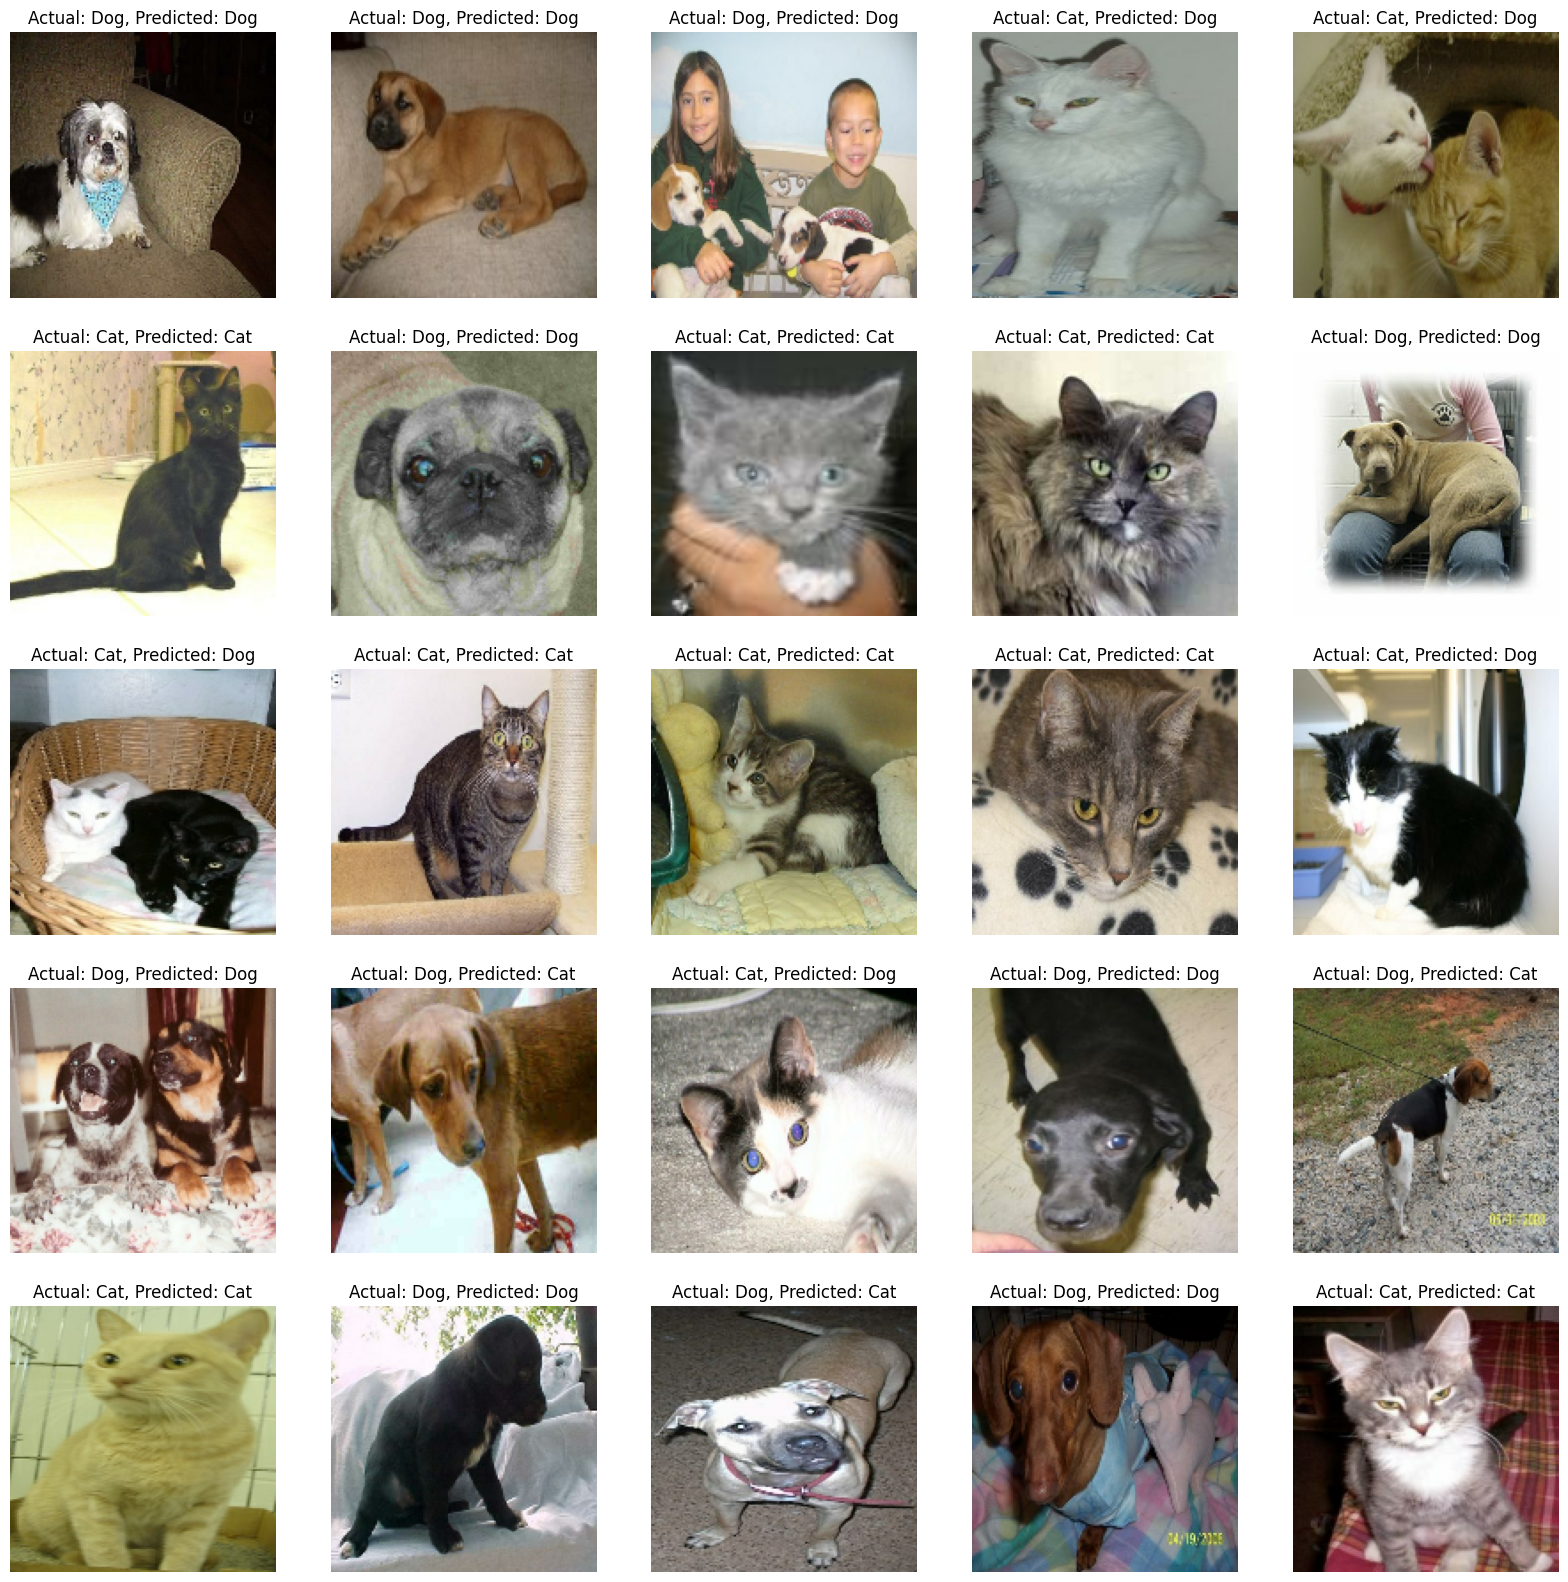

In [93]:
import random
import matplotlib.pyplot as plt

# Make predictions on the test data
predictions = model.predict(test_data)

# Define a function to plot images with their actual and predicted labels
def plot_images(images, labels, predictions):
    num_images = len(images)
    num_rows = (num_images + 4) // 5  # Calculate number of rows needed
    plt.figure(figsize=(20, num_rows * 4))  # Adjust figsize based on number of rows
    for i in range(num_images):
        plt.subplot(num_rows, 5, i+1)
        plt.imshow(images[i])
        actual_label = "Dog" if labels[i] == 1 else "Cat"
        predicted_label = "Dog" if predictions[i] >= 0.5 else "Cat"
        plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        plt.axis('off')
    plt.show()

# Extract a few random samples from the test data for visualization
num_images_to_display = 25
sample_images = []
sample_labels = []
sample_predictions = []

# Select random indices from the test dataset
random_indices = random.sample(range(len(test_data)), num_images_to_display)

# Extract images and labels corresponding to the selected indices
for i in random_indices:
    image_batch, label_batch = list(test_data.skip(i).take(1))[0]
    sample_images.append(image_batch[0].numpy())  # Extract the first image from the batch
    sample_labels.append(label_batch[0].numpy())  # Extract the first label from the batch

# Convert predictions to binary labels (0 for cat, 1 for dog)
sample_predictions = [1 if prediction >= 0.5 else 0 for prediction in predictions[random_indices]]

# Plot the sample images with their actual and predicted labels
plot_images(sample_images, sample_labels, sample_predictions)